In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('common')

import datetime
from print_more_stuff import print_more_stuff
from regression_models import dosomething
from pprint import pprint
from preprocessing import mean_and_std
from writejson import write_json
from writeresults import write_results

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from sklearn.svm import SVR 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20480 entries, 0 to 20479
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             20480 non-null  float64
 1   bath            20480 non-null  float64
 2   acre_lot        20480 non-null  float64
 3   zip_code        20480 non-null  float64
 4   house_size      20480 non-null  float64
 5   price           20480 non-null  float64
 6   prev_sold_year  20480 non-null  float64
 7   latitude        20480 non-null  float64
 8   longitude       20480 non-null  float64
 9   county          20480 non-null  float64
dtypes: float64(10)
memory usage: 1.6 MB


In [4]:
switches = {
    "which_df":"outliers",
    "normalize":False,
    "model":"SVR"
}
state = "nj"
# False True onezipcode onecounty outliers allzipcodes allcounties
# "Linear Regression" "KNearest Neighbor" "Decision Tree" "Polynomial" "Lasso" "Ridge" "SVR"
# "Random Forest" "Hist Gradient Boosting" "Gradient Boosting" "Adaboost"

In [5]:
groupby_zipcode = outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)
groupby_zipcode_df = pd.DataFrame(groupby_zipcode).rename(columns={"zip_code":"count"}).reset_index()
first_zipcode = groupby_zipcode_df.iloc[0]["zip_code"]
first_zipcode

8527.0

In [6]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([first_zipcode])]

In [7]:
one_zipcode_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 269 entries, 10338 to 10606
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             269 non-null    float64
 1   bath            269 non-null    float64
 2   acre_lot        269 non-null    float64
 3   zip_code        269 non-null    float64
 4   house_size      269 non-null    float64
 5   price           269 non-null    float64
 6   prev_sold_year  269 non-null    float64
 7   latitude        269 non-null    float64
 8   longitude       269 non-null    float64
 9   county          269 non-null    float64
dtypes: float64(10)
memory usage: 23.1 KB


In [8]:
groupby_county = outliers_df.groupby(["county"])["county"].count().sort_values(ascending=False)
groupby_county_df = pd.DataFrame(groupby_county).rename(columns={"county":"count"}).reset_index()
first_county = groupby_county_df.iloc[0]["county"]
first_county

0.0

In [9]:
one_county_df = outliers_df[outliers_df["county"].isin([first_county])]

In [10]:
one_county_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1721 entries, 13052 to 19278
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             1721 non-null   float64
 1   bath            1721 non-null   float64
 2   acre_lot        1721 non-null   float64
 3   zip_code        1721 non-null   float64
 4   house_size      1721 non-null   float64
 5   price           1721 non-null   float64
 6   prev_sold_year  1721 non-null   float64
 7   latitude        1721 non-null   float64
 8   longitude       1721 non-null   float64
 9   county          1721 non-null   float64
dtypes: float64(10)
memory usage: 147.9 KB


In [11]:
which_dataframe = outliers_df
match switches["which_df"]:
    case "onezipcode":
        which_dataframe = one_zipcode_df
    case "onecounty":
        which_dataframe = one_county_df
    case "allzipcodes":
        which_dataframe = outliers_df
    case "allcounties":
        which_dataframe = outliers_df
    case _:
        which_dataframe = outliers_df

In [12]:
normalize_df = which_dataframe

params = {
    "data":which_dataframe,
    "features_a":["prev_sold_year","zip_code","latitude","longitude","county"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}

match switches["normalize"]:
    case True:
        normalize_df = mean_and_std(params)

normalize_df.tail()

,bed,bath,acre_lot,zip_code,house_size,price,prev_sold_year,latitude,longitude,county
20475,4.0,3.0,0.94,8886.0,1500.0,579000.0,2019.0,40.687502,-75.101127,17.0
20476,3.0,3.0,0.11,8886.0,1500.0,356000.0,2006.0,40.687502,-75.101127,17.0
20477,3.0,2.0,0.23,8886.0,1500.0,69800.0,2021.0,40.687502,-75.101127,17.0
20478,4.0,3.0,0.31,8886.0,1500.0,459000.0,2009.0,40.687502,-75.101127,17.0
20479,3.0,2.0,0.14,8886.0,1500.0,79900.0,2020.0,40.687502,-75.101127,17.0


In [13]:
normalize_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20480 entries, 0 to 20479
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             20480 non-null  float64
 1   bath            20480 non-null  float64
 2   acre_lot        20480 non-null  float64
 3   zip_code        20480 non-null  float64
 4   house_size      20480 non-null  float64
 5   price           20480 non-null  float64
 6   prev_sold_year  20480 non-null  float64
 7   latitude        20480 non-null  float64
 8   longitude       20480 non-null  float64
 9   county          20480 non-null  float64
dtypes: float64(10)
memory usage: 1.6 MB


In [14]:
norm_features = ["acre_lot","bed","bath","house_size","prev_sold_year","price"]

match switches["which_df"]:
    case "allzipcodes":
        norm_features.append("zip_code")
    case "allcounties":
        norm_features.append("county")
    case _:
        norm_features.append("latitude")
        norm_features.append("longitude")
                             
correlation = normalize_df[norm_features].corr()
correlation["price"]

acre_lot          0.013009
bed               0.453542
bath              0.618459
house_size        0.361332
prev_sold_year    0.031241
price             1.000000
latitude          0.118985
longitude         0.270237
Name: price, dtype: float64

Text(0.5, 1.0, 'Correlation Between Variables')

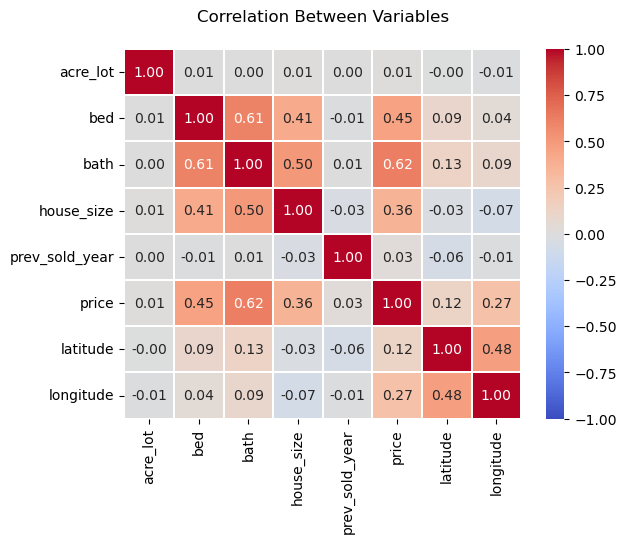

In [15]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

In [16]:
corrfeatures = ["county","latitude","longitude","zip_code"]

match switches["which_df"]:
    case "onezipcode":
        corrfeatures = []
    case "onecounty":
        corrfeatures = []
    case "allzipcodes":
        corrfeatures = ["zip_code"]
    case "allcounties":
        corrfeatures = ["county"]
    case _:
        corrfeatures = ["latitude","longitude"]


for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.20:
        corrfeatures.append(feature)
        
savefeatures = list(dict.fromkeys(corrfeatures))
print(savefeatures)

['latitude', 'longitude', 'bed', 'bath', 'house_size']


In [17]:
pariplot_features = []
for feature, value in correlation["price"].items():
        pariplot_features.append(feature)

In [18]:
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

In [19]:
X = normalize_df[features]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [20]:
model_gscv = None
model_predictions = None

In [21]:
if switches["model"] == "KNearest Neighbor":
    knn_params = {'n_neighbors': range(20, 25, 1)}
    knn_gscv = GridSearchCV(KNeighborsRegressor(), param_grid=knn_params, cv=5).fit(X, y)
    knn_gscv.best_params_
    knn = KNeighborsRegressor(**knn_gscv.best_params_)
    
    model_gscv = GridSearchCV(knn, param_grid={}, cv=5)
    
    knn_model = model_gscv.fit(X_train,y_train)
    
    model_predictions = knn_model.predict(X_test)

In [22]:
if switches["model"] == "Decision Tree":

    dtree_params = {'max_depth': range(1,6,1),
         'random_state':[42]}
    dtree_gscv = GridSearchCV(DecisionTreeRegressor(), param_grid=dtree_params).fit(X, y)
    dtree_gscv.best_params_

    dtree = DecisionTreeRegressor(**dtree_gscv.best_params_)
    
    model_gscv = GridSearchCV(dtree, param_grid={})
    
    dtree_model = model_gscv.fit(X_train,y_train)
    
    model_predictions = dtree_model.predict(X_test)

In [23]:
if switches["model"] == "Linear Regression":
    lgr = LinearRegression(fit_intercept=False)
    
    model_gscv = GridSearchCV(lgr, param_grid={})
    
    lgr_model = model_gscv.fit(X_train,y_train)
    
    model_predictions = lgr_model.predict(X_test)

In [24]:
if switches["model"] == "Polynomial":
    poly_pipeline = Pipeline([
        ('poly_features', PolynomialFeatures()), 
        ('poly_model', LinearRegression())
    ])
    
    poly_degrees = range(1,5,1)
    
    poly_pipeline_params={"poly_features__degree":poly_degrees,"poly_features__include_bias":[False],"poly_model__fit_intercept":[True]}
    poly_grid_searchcv = GridSearchCV(poly_pipeline, param_grid=poly_pipeline_params, cv=5, verbose=1)
    poly_grid_searchcv.fit(X, y)
    
    poly_grid_searchcv.best_params_

    poly_best_params = {}
    for what in poly_grid_searchcv.best_params_:
        if poly_best_params.get(what) == None:
            poly_best_params[what] = []
        poly_best_params[what].append(poly_grid_searchcv.best_params_[what])

    poly_pipeline = Pipeline([
        ('poly_features', PolynomialFeatures()), 
        ('poly_model', LinearRegression())
    ])
    
    model_gscv = GridSearchCV(poly_pipeline, param_grid=poly_best_params, cv=5, verbose=1)
    
    poly_model = model_gscv.fit(X_train, y_train)
    
    model_predictions = poly_model.predict(X_test)

In [25]:
if switches["model"] == "Lasso":
    myrange = []
    for i in range(7,12):
        myrange.append(10**-i)
    param_dict = {'alpha': myrange}
    lasso_gscv = GridSearchCV(Lasso(), param_grid=param_dict, scoring='neg_mean_squared_error')
    lasso_gscv_model = lasso_gscv.fit(X, y)

    lasso_reg = Lasso(**lasso_gscv.best_params_)

    model_gscv = GridSearchCV(lasso_reg, param_grid={})
    
    lasso_model = model_gscv.fit(X_train,y_train)
    
    model_predictions = lasso_model.predict(X_test)

    print(lasso_gscv.best_params_)

In [26]:
if switches["model"] == "Ridge":
    myrange = []
    for i in range(10,17):
        myrange.append(10**-i)
    param_dict = {'alpha': myrange}
    ridge_gscv = GridSearchCV(Ridge(), param_grid=param_dict, scoring='neg_mean_squared_error')
    ridge_gscv_model = ridge_gscv.fit(X, y)
    
    ridge_reg = Ridge(**ridge_gscv.best_params_)

    model_gscv = GridSearchCV(ridge_reg, param_grid={})
    
    ridge_model = model_gscv.fit(X_train,y_train)
    
    model_predictions = ridge_model.predict(X_test)

    print(ridge_gscv.best_params_)

In [32]:
if switches["model"] == "SVR":
#    cv_scores = []
    kernels = ['linear']
#    for k in kernels:
#        svr = SVR(kernel=k)
#        scores = cross_val_score(svr, X, y, cv=5, scoring='accuracy')
#        cv_scores.append(scores.mean())

#    optimal_kernel = kernels[cv_scores.index(max(cv_scores))]
#    print(f"Optimal kernel is {optimal_kernel} with cross-validation score of {max(cv_scores)}")
    
    params = {
        'C': [1],
        'gamma': [1],
        'epsilon': [0.2],
        'kernel': kernels
    }
    
    svr_gscv = GridSearchCV(SVR(), params, refit=True, verbose=2, cv=5).fit(X, y)
    print(f"Best parameters found: {svr_gscv.best_params_}")
    
    svr = SVR(**svr_gscv.best_params_)
    model_gscv = GridSearchCV(svr, param_grid={})
    svr_model = model_gscv.fit(X_train,y_train)
    model_predictions = svr_model.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...........C=1, epsilon=0.2, gamma=1, kernel=linear; total time=  15.0s
[CV] END ...........C=1, epsilon=0.2, gamma=1, kernel=linear; total time=  13.6s
[CV] END ...........C=1, epsilon=0.2, gamma=1, kernel=linear; total time=  13.7s
[CV] END ...........C=1, epsilon=0.2, gamma=1, kernel=linear; total time=  16.2s
[CV] END ...........C=1, epsilon=0.2, gamma=1, kernel=linear; total time=  15.7s
Best parameters found: {'C': 1, 'epsilon': 0.2, 'gamma': 1, 'kernel': 'linear'}


In [ ]:
if switches["model"] == "Adaboost":
    adaboost = AdaBoostRegressor()
    model_gscv = GridSearchCV(adaboost, param_grid={})
    adaboost_model = model_gscv.fit(X_train,y_train)
    model_predictions = adaboost_model.predict(X_test)

In [ ]:
if switches["model"] == "Gradient Boosting":
    grboost = GradientBoostingRegressor()
    model_gscv = GridSearchCV(grboost, param_grid={})
    grboost_model = model_gscv.fit(X_train,y_train)
    model_predictions = grboost_model.predict(X_test)

In [ ]:
if switches["model"] == "Hist Gradient Boosting":
    histgrboost = HistGradientBoostingRegressor()
    model_gscv = GridSearchCV(histgrboost, param_grid={})
    histgrboost_model = model_gscv.fit(X_train,y_train)
    model_predictions = histgrboost_model.predict(X_test)

In [ ]:
if switches["model"] == "Random Forest":
    rf = RandomForestRegressor()
    model_gscv = GridSearchCV(rf, param_grid={})
    rf_model = model_gscv.fit(X_train,y_train)
    model_predictions = rf_model.predict(X_test)

In [33]:
pms_config = {
    "title":switches["model"], 
    "y_param":y_test, 
    "predictions":model_predictions, 
    "gscv":model_gscv
}

In [34]:
results = print_more_stuff(pms_config)
results["dataframe"] = switches["which_df"]
results["normalized"] = switches["normalize"]

SVR EVS = 0.142713897
SVR MSE = 164,405,845,138.268402
SVR MAE = 235,673.162469
SVR R2 = 0.086742
SVR Fit Time = 4.754327821731567


In [35]:
results_dict = write_results(results,state)

In [36]:
predict_df = pd.DataFrame(model_predictions).reset_index()
predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

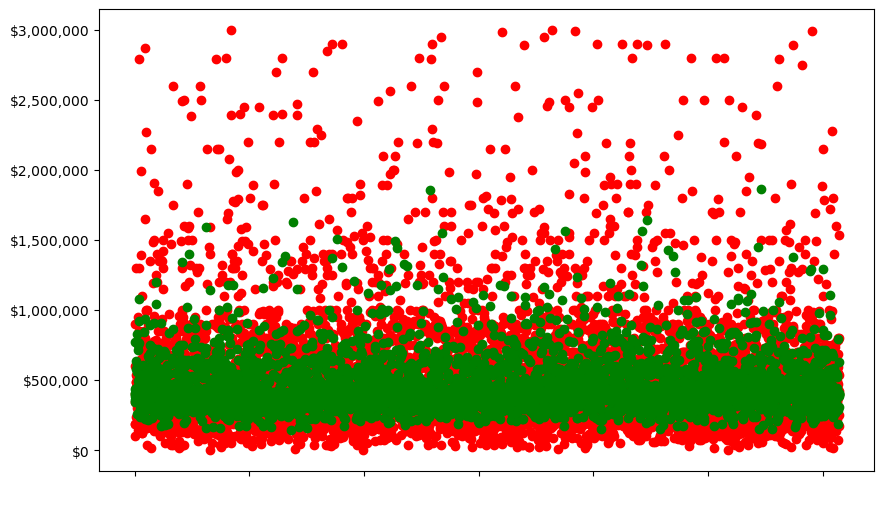

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(predict_df.index,predict_df["prediction"], color="green")
plt.show()

In [38]:
results_dict

{'dataframe': 'outliers',
 'normalized': False,
 'timestamp': '2024/03/26 08:54:28',
 'model': 'SVR',
 'explained variance score': '0.142713897',
 'mae score': '235,673.162469',
 'mse score': '164,405,845,138.268402',
 'r2 score': '0.086742',
 'mean fit time': 4.754327821731567}

In [39]:
results_df = pd.read_json(state+ "/results.json")

model_comparisons = results_df.set_index('model').sort_values("r2 score", ascending=True)
model_comparisons

,dataframe,normalized,timestamp,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,,,,
SVR,outliers,False,2024-03-26 08:54:28,0.142714,"235,673.162469","164,405,845,138.268402",0.086742,4.754328
Linear Regression,outliers,False,2024-03-25 17:56:27,0.398629,"206,996.841822","108,288,728,535.588120",0.398467,0.008957
KNearest Neighbor,allcounties,False,2024-03-25 18:53:50,0.420863,"194,999.488044","104,257,119,453.111008",0.420862,0.006948
Polynomial,outliers,False,2024-03-25 18:07:27,0.439942,"200,275.324785","100,870,089,629.248779",0.439677,0.003124
Ridge,outliers,False,2024-03-25 18:37:19,0.439942,"200,275.324785","100,870,089,629.252762",0.439677,0.003128
Lasso,outliers,False,2024-03-25 18:40:54,0.439942,"200,275.324785","100,870,089,629.252625",0.439677,0.343729
KNearest Neighbor,outliers,False,2024-03-25 17:26:13,0.446805,"186,090.545869","99,656,838,348.666946",0.446416,0.002388
KNearest Neighbor,outliers,False,2024-03-25 17:55:56,0.446805,"186,090.545869","99,656,838,348.666946",0.446416,0.000000
Decision Tree,outliers,False,2024-03-25 18:02:14,0.457935,"199,782.703570","97,583,672,763.171021",0.457933,0.008657
